# Assets Failure Analysis and Prediction using Machine Learning

Author: Juan Miguel Estrada - jmestradag@gmail.com

Data Source: https://mydatamodels.zendesk.com/hc/en-us/article_attachments/360037092371/Failure_prediction_-_For_prediction.csv

Check README file for further info on this project.


## Analysis Assumptions:

1. Reader is familiar with reliability engineering concepts for machinery, which is a field of study that deals with the estimation, prevention, and management of failures by
combining statistics, risk analysis, and physics.
2. These machines works as repairable systems and each time they fail, they are repaired in "as good as new" condition.
3. Operation timeframe given is in weeks, so these machines have an operating context of a 24/7 fashion, so operating time is similar across units and therefore will be treated in weeks, which will be our unit for maintenance planning and scheduling.
4. Time to failure given as lifetime, is recorded since last failure or start of operation for each machine.
5. This fleet of machines are very similar in design, and operates under same conditions.
6. Failure mode under analysis is similar and related to same sub-system with key variables: Temperature, Pressure and Moisture.
7. Due to lack of operating, maintaining and repairing costs, this analysis will assume a direct relationship between failures and costs and therefore this analysis can not use optimal replacement algorithm.


In [173]:
# Ignore user warnings
import warnings
warnings.simplefilter("ignore", UserWarning)

import numpy  as np
import pandas as pd
import matplotlib
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import plotly.graph_objs as go
from reliability.Fitters import Fit_Everything
from reliability.Repairable_systems import ROCOF
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics

%matplotlib inline
plt.style.use('ggplot')

## Exploratory Data Analysis (EDA)

In [241]:
df = pd.read_csv('Failure-prediction-for-model-creation.csv')
#df

In [3]:
# check for missing data and proportion of broken (yes / no)
df.groupby(['broken']).count()

Random  Machine nbr  lifetime  pressureInd  moistureInd  \
broken                                                            
No         422          422       422          422          422   
Yes        278          278       278          278          278   

        temperatureInd  team  provider  
broken                                  
No                 422   422       422  
Yes                278   278       278

### Continuous variables analysis

Text(0.5, 1.0, 'Violinplot of Temperature vs. Broken')

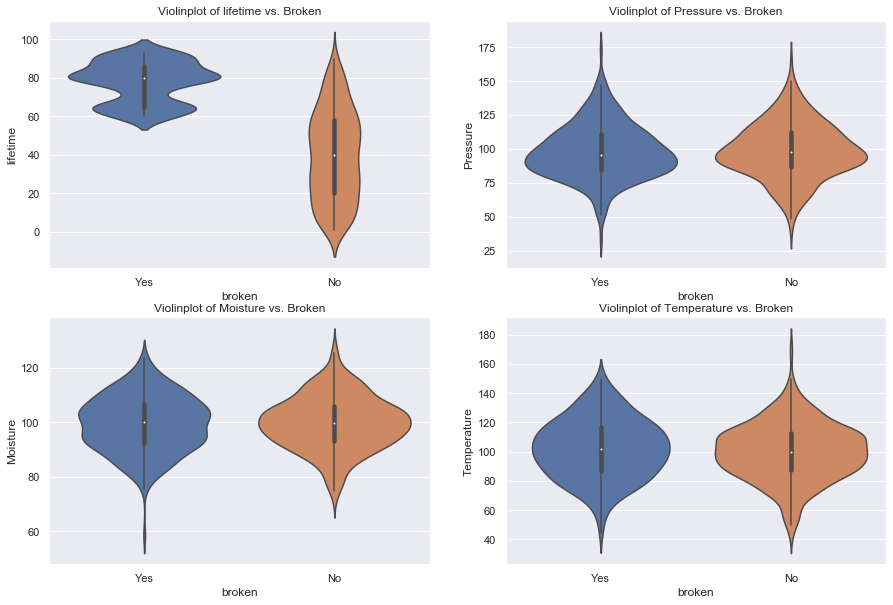

In [6]:
# Plotting variables against target to check for patterns
plt.figure(figsize=(15,10))
plt.subplot(221)
sns.violinplot(x='broken', y='lifetime', data=df)
plt.ylabel("lifetime")
plt.title("Violinplot of lifetime vs. Broken")
plt.subplot(222)
sns.violinplot(x='broken', y='pressureInd', data=df)
plt.ylabel("Pressure")
plt.title("Violinplot of Pressure vs. Broken")
plt.subplot(223)
sns.violinplot(x='broken', y='moistureInd', data=df)
plt.ylabel("Moisture")
plt.title("Violinplot of Moisture vs. Broken")
plt.subplot(224)
sns.violinplot(x='broken', y='temperatureInd', data=df)
plt.ylabel("Temperature")
plt.title("Violinplot of Temperature vs. Broken")

Distributions of continuous variables against response is similar only lifetime variable seems to be the exception, as can be seen on plot above.

### Categorical variable analysis - Operational analysis

Let's check performance of machines broken per team and supplier in order to find interesting patterns. Dataframe should be splitted into a subset of data for broken machines in order to drill down on which supplier and team has worst performance.

In [240]:
#splitting dataset for gettingbroken dataset
broken_df = df[df['broken']== 'Yes']
#broken_df

Text(0.5, 1.0, 'Countplot of Supplier and Team')

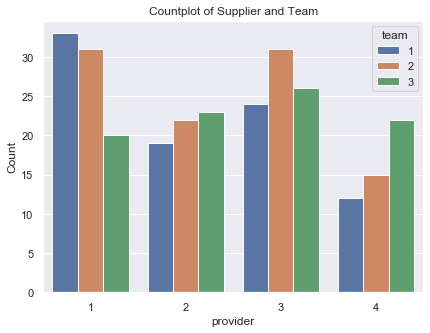

In [8]:
# Plotting variables against target to check for patterns
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.countplot(x='provider', hue='team', data=broken_df)
plt.ylabel("Count")
plt.title("Countplot of Supplier and Team")

Text(0.5, 1.0, 'Violinplot of Lifetime vs. Team')

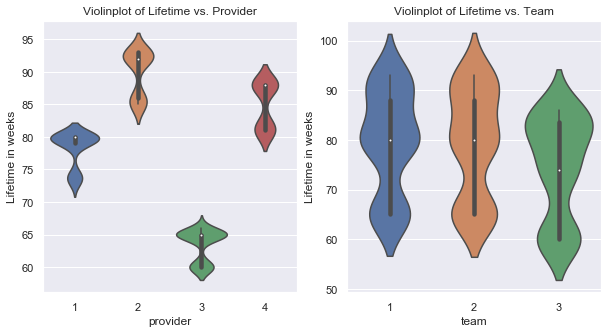

In [9]:
# Plotting variables against target to check for patterns
plt.figure(figsize=(10,5))
plt.subplot(121)
sns.violinplot(x='provider', y='lifetime', data=broken_df)
plt.ylabel("Lifetime in weeks")
plt.title("Violinplot of Lifetime vs. Provider")
plt.subplot(122)
sns.violinplot(x='team', y='lifetime', data=broken_df)
plt.ylabel("Lifetime in weeks")
plt.title("Violinplot of Lifetime vs. Team")


From plot above, at simple sight, it appears that all teams has a similar performance, even though main finding is that provider 3 has the worst performance in lifetime achieved before failure occurs, a verification of key operating parameters must be run against providers in order to discard bad operating conditions in provider 3 machinery.

Text(0.5, 1.0, 'Violinplot of Moisture vs. Provider')

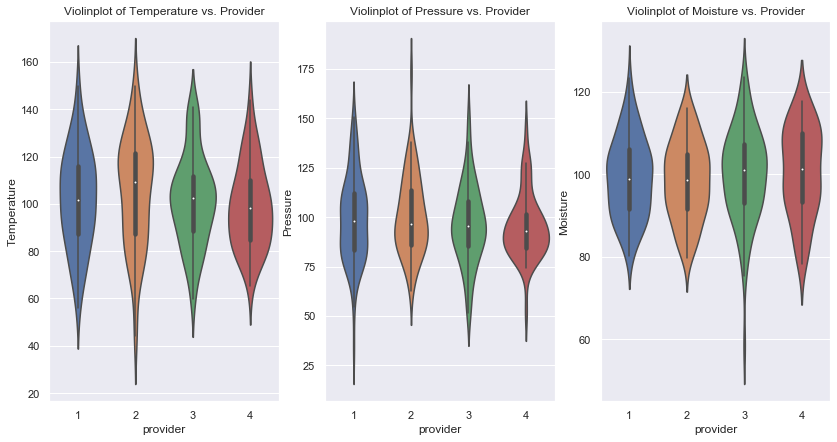

In [10]:
# Plotting variables against target to check for patterns
plt.figure(figsize=(14,7))
plt.subplot(131)
sns.violinplot(x='provider', y='temperatureInd', data=broken_df)
plt.ylabel("Temperature")
plt.title("Violinplot of Temperature vs. Provider")
plt.subplot(132)
sns.violinplot(x='provider', y='pressureInd', data=broken_df)
plt.ylabel("Pressure")
plt.title("Violinplot of Pressure vs. Provider")
plt.subplot(133)
sns.violinplot(x='provider', y='moistureInd', data=broken_df)
plt.ylabel("Moisture")
plt.title("Violinplot of Moisture vs. Provider")


From plot above, at simple sight, it appears that no bad operating conditions is found, all key operating variables distributions are very similar, however, process limit values for each key variable should be consulted in standard operating procedures or OEM service manuals in order to confirm whether a bad operating condition was carried out by operators that can be helpful to understand why this supplier is lagging behind in performance which is detrimental to company's goals like increase production throughput, ruling out first internal variables within company's control reach, and then, if no internal variable is found responsible, then management can take decisions on whether to continue with future asset purchases to this supplier.

In [11]:
#Calculate stats for control chart of temperature 
broken_df['temp_avg'] = broken_df['temperatureInd'].mean()
broken_df['temp_std'] = broken_df['temperatureInd'].std()
broken_df['temp_ucl'] = broken_df['temp_avg'] + (3*broken_df['temp_std'])
broken_df['temp_lcl'] = broken_df['temp_avg'] - (3*broken_df['temp_std'])

In [15]:
#Calculate stats for control chart of pressure
broken_df['press_avg'] = broken_df['pressureInd'].mean()
broken_df['press_std'] = broken_df['pressureInd'].std()
broken_df['press_ucl'] = broken_df['press_avg'] + (3*broken_df['press_std'])
broken_df['press_lcl'] = broken_df['press_avg'] - (3*broken_df['press_std'])

In [17]:
#Calculate stats for control chart of moisture
broken_df['moist_avg'] = broken_df['moistureInd'].mean()
broken_df['moist_std'] = broken_df['moistureInd'].std()
broken_df['moist_ucl'] = broken_df['moist_avg'] + (3*broken_df['moist_std'])
broken_df['moist_lcl'] = broken_df['moist_avg'] - (3*broken_df['moist_std'])

In [27]:
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=broken_df.index, y=broken_df['temp_ucl'], name='UCL'))
fig.add_trace(go.Scatter(x=broken_df.index, y=broken_df['temp_lcl'], name='LCL'))
fig.add_trace(go.Scatter(x=broken_df.index, y=broken_df['temp_avg'], name = 'AVG'))
fig.add_trace(go.Scatter(x=broken_df.index, y=broken_df['temperatureInd'], name='Temp'))

# Edit the layout
title_string = 'Control chart for temperature'
fig.update_layout(title=title_string, xaxis_title='Index', yaxis_title='Variable levels')
fig.update_traces(mode='lines')
fig.show()

In [28]:
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=broken_df.index, y=broken_df['press_ucl'], name='UCL'))
fig.add_trace(go.Scatter(x=broken_df.index, y=broken_df['press_lcl'], name='LCL'))
fig.add_trace(go.Scatter(x=broken_df.index, y=broken_df['press_avg'], name = 'AVG'))
fig.add_trace(go.Scatter(x=broken_df.index, y=broken_df['pressureInd'], name='Press'))

# Edit the layout
title_string = 'Control chart for pressure'
fig.update_layout(title=title_string, xaxis_title='Index', yaxis_title='Variable levels')
fig.update_traces(mode='lines')
fig.show()

In [29]:
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=broken_df.index, y=broken_df['moist_ucl'], name='UCL'))
fig.add_trace(go.Scatter(x=broken_df.index, y=broken_df['moist_lcl'], name='LCL'))
fig.add_trace(go.Scatter(x=broken_df.index, y=broken_df['moist_avg'], name = 'AVG'))
fig.add_trace(go.Scatter(x=broken_df.index, y=broken_df['moistureInd'], name='Moist'))

# Edit the layout
title_string = 'Control chart for moisture'
fig.update_layout(title=title_string, xaxis_title='Index', yaxis_title='Variable levels')
fig.update_traces(mode='lines')
fig.show()

Looking at control charts above we can conclude there is no evidence of bad operation, because key variables such as: temperature, pressure and moisture are within statistical control limits; bearing in mind that, dataset did not provided operating control limits to these variables. 

Pressure with just one outlier corresponding to provider 2 as can be seen on violin plots, and moisture with just one outlier corresponding to provider 3 which could explain a possible problem with one asset failing before due time; but it can not explain all premature failures from all assets of provider 3.

Therefore, causes related to provider 3 such as: materials quality, manufacturing process, and quality control issues should be explored in previous failure root cause analysis (RCA) in order to confirm this hypothesis (outside of scope of this project).

Take note that we are not considering another cause related to operations that could be checked before ruling out provider as responsible, because of distribution of data in violin plots, where there are no outliers indicating a maintenance issue such as: problems related to installation, start up and commissioning of assets.

Now, this validation should be done with reliability tools!

In [37]:
#splitting dataset for getting failure data from each provider
broken_df1 = broken_df[broken_df['provider']==1]
broken_df2 = broken_df[broken_df['provider']==2]
broken_df3 = broken_df[broken_df['provider']==3]
broken_df4 = broken_df[broken_df['provider']==4]

In [38]:
#creating variables of faliure data for each provider
lifetime1 = broken_df1['lifetime']
lifetime2 = broken_df2['lifetime']
lifetime3 = broken_df3['lifetime']
lifetime4 = broken_df4['lifetime']

In [242]:
#splitting dataset for non broken dataset
no_broken_df = df[df['broken']== 'No']
#no_broken_df

In [49]:
#splitting dataset for getting non failure data - right censored from each provider
no_broken_df1 = no_broken_df[no_broken_df['provider']==1]
no_broken_df2 = no_broken_df[no_broken_df['provider']==2]
no_broken_df3 = no_broken_df[no_broken_df['provider']==3]
no_broken_df4 = no_broken_df[no_broken_df['provider']==4]

In [51]:
##creating variables of non-faliure data - right censored for each provider
lifetime1c = no_broken_df1['lifetime']
lifetime2c = no_broken_df2['lifetime']
lifetime3c = no_broken_df3['lifetime']
lifetime4c = no_broken_df4['lifetime']

                   Alpha     Beta    Gamma       Mu      Sigma      Lambda     AICc      BIC
Distribution                                                                                
Weibull_2P       79.4091  51.1339                                           368.385  374.657
Weibull_3P       79.4091  51.1339        0                                  370.455  379.827
Normal_2P                                   78.3445    2.62933               407.17  413.442
Lognormal_2P                                4.70909   0.360247              803.236  809.508
Lognormal_3P                             0  4.36055  0.0342917              412.701  809.508
Exponential_1P                                                   0.0084147  972.697  975.845
Exponential_2P                       0.999                      0.00856516  971.758   978.03
Gamma_2P        0.366342  213.761                                                           
Gamma_3P         6.92965  19.1252 -75.7868                            

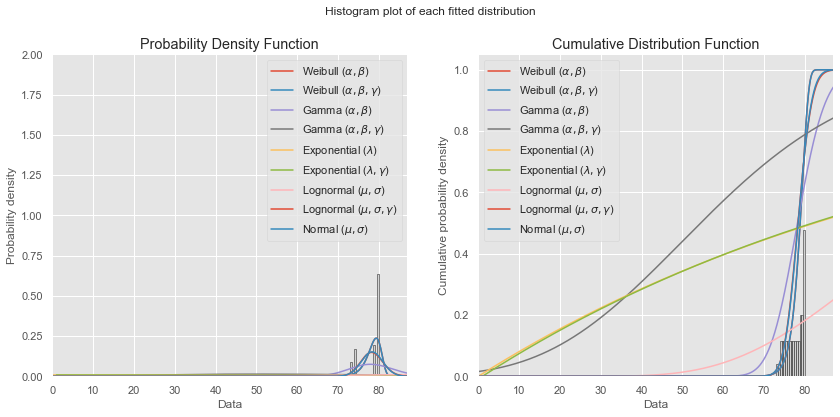

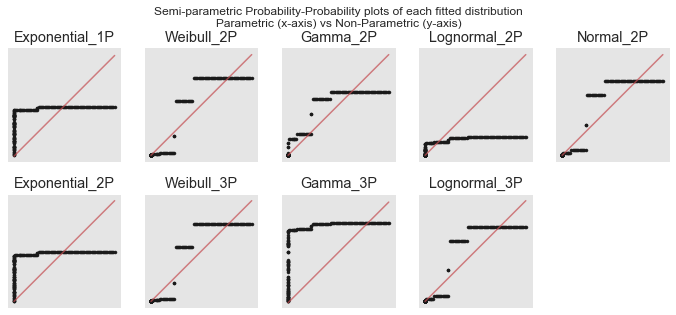

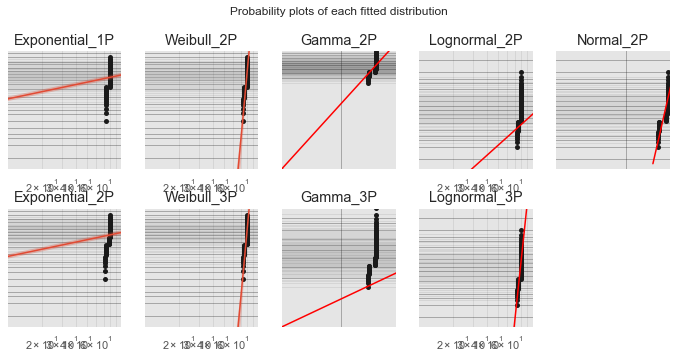

The best fitting distribution was Weibull_2P which had parameters [79.40910508 51.13386826  0.        ]


In [58]:
#finding which model fits best the data provided
results = Fit_Everything(failures=lifetime1.values, right_censored=lifetime1c.values)

print('The best fitting distribution was', results.best_distribution_name, 'which had parameters', results.best_distribution.parameters)

                   Alpha     Beta      Gamma       Mu     Sigma      Lambda     AICc      BIC
Distribution                                                                                 
Weibull_2P       91.5071   37.664                                            331.106  337.481
Weibull_3P       91.5071   37.664          0                                 333.173  342.702
Normal_2P                                     90.0091   3.37629              344.715  351.089
Lognormal_2P                                  4.95228  0.656458               688.97  695.345
Lognormal_3P                       0.0262092  4.58991   0.10153              469.576  695.345
Exponential_1P                                                   0.00602923  784.248  787.446
Exponential_2P                         0.999                     0.00613605  784.044  790.418
Gamma_2P        0.521104   172.56                                                            
Gamma_3P         4.93711  39.2222   -136.265                

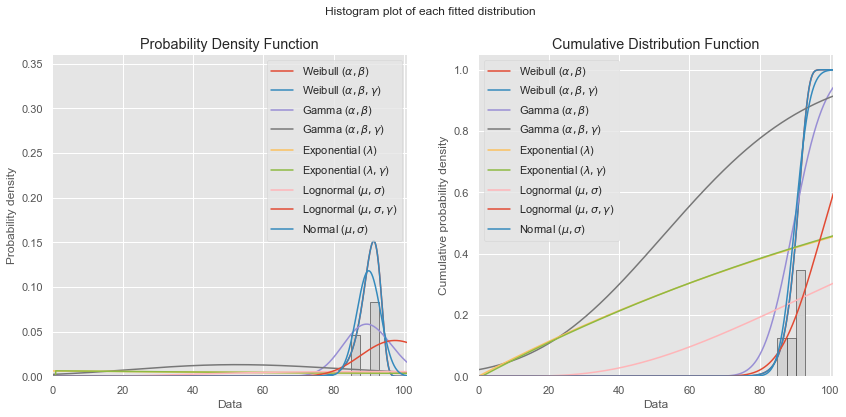

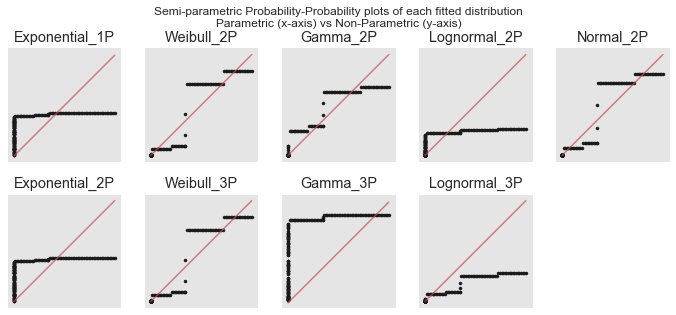

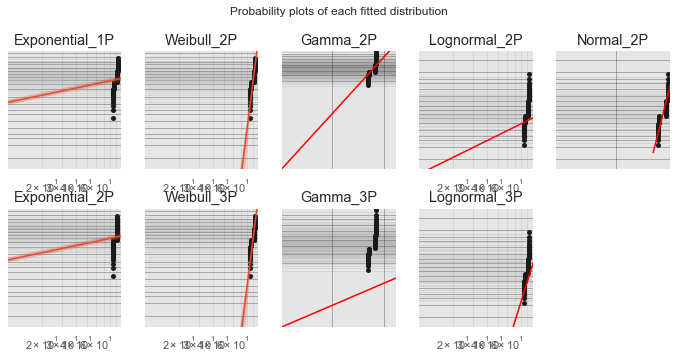

The best fitting distribution was Weibull_2P which had parameters [91.50712704 37.66399273  0.        ]


In [59]:
#finding which model fits best the data provided
results = Fit_Everything(failures=lifetime2.values, right_censored=lifetime2c.values)

print('The best fitting distribution was', results.best_distribution_name, 'which had parameters', results.best_distribution.parameters)

                   Alpha     Beta      Gamma       Mu     Sigma     Lambda     AICc      BIC
Distribution                                                                                
Weibull_2P       64.5401  41.0623                                               355  361.295
Weibull_3P       64.5401  41.0623          0                                357.069  366.477
Normal_2P                                     63.5484   2.34314             378.586  384.881
Lognormal_2P                                   4.5412  0.388284             761.916  768.211
Lognormal_3P                       0.0243257  4.17437  0.085666             458.168  768.211
Exponential_2P                         1.999                     0.0100719  910.946  917.241
Exponential_1P                                                   0.0096451  915.913  919.072
Gamma_2P        0.355488  178.471                                                           
Gamma_3P         2.48506  75.6089   -140.443                          

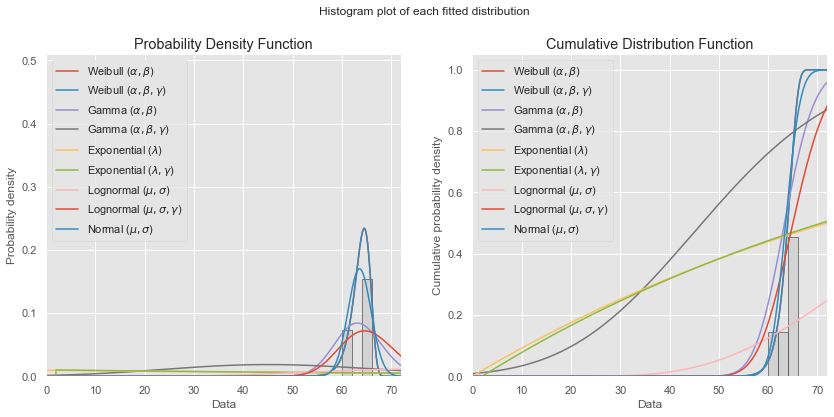

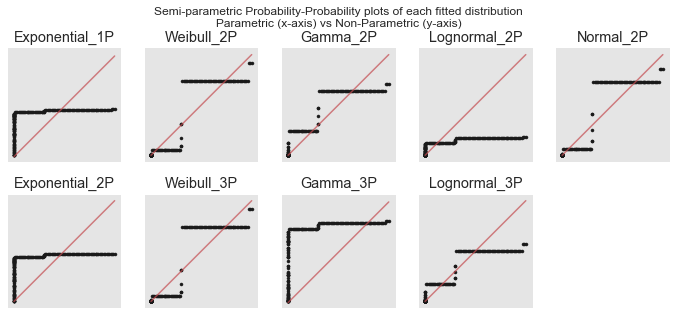

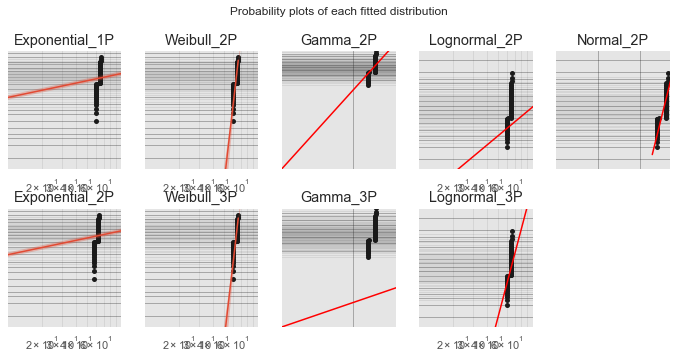

The best fitting distribution was Weibull_2P which had parameters [64.54014887 41.06228983  0.        ]


In [60]:
#finding which model fits best the data provided
results = Fit_Everything(failures=lifetime3.values, right_censored=lifetime3c.values)

print('The best fitting distribution was', results.best_distribution_name, 'which had parameters', results.best_distribution.parameters)

                   Alpha     Beta      Gamma       Mu     Sigma      Lambda     AICc      BIC
Distribution                                                                                 
Weibull_2P       86.8947  34.1057                                            270.209  276.296
Weibull_3P       86.8947  34.1057          0                                 272.286  281.377
Normal_2P                                     85.4264   3.38307              275.786  281.873
Gamma_2P        0.536922  159.367                                              309.8  315.887
Lognormal_2P                                  4.91413  0.564201              522.324   528.41
Lognormal_3P                       0.0208906   4.4752  0.109156              338.976   528.41
Exponential_1P                                                   0.00519009  615.603  618.659
Exponential_2P                         1.999                     0.00537344  614.255  620.341
Gamma_3P         7.12094  16.1172   -56.2422                

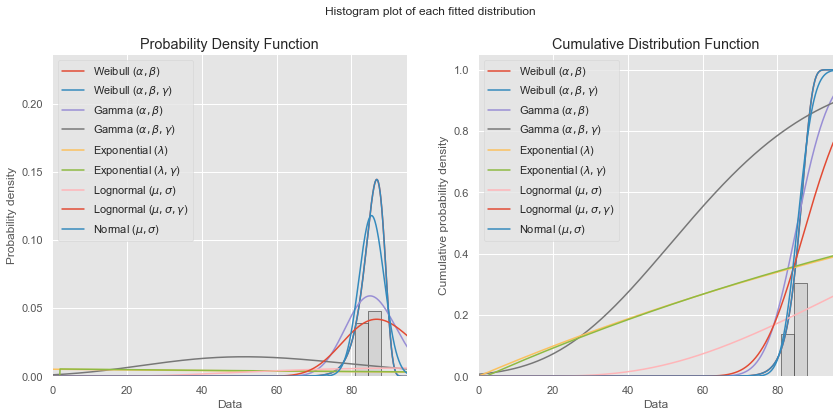

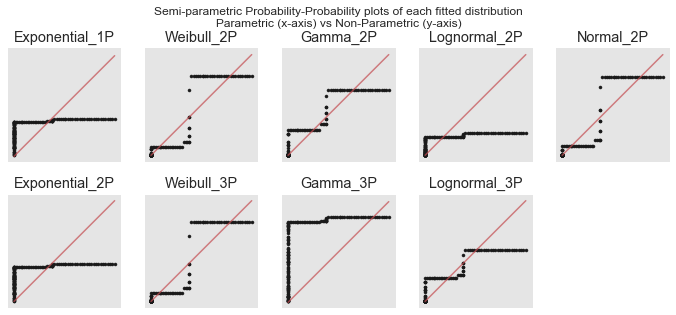

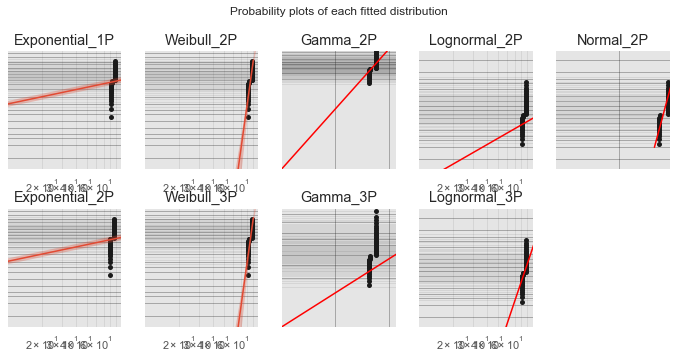

The best fitting distribution was Weibull_2P which had parameters [86.89467959 34.10573932  0.        ]


In [61]:
#finding which model fits best the data provided
results = Fit_Everything(failures=lifetime4.values, right_censored=lifetime4c.values)

print('The best fitting distribution was', results.best_distribution_name, 'which had parameters', results.best_distribution.parameters)

As can be seen on plots above, Weibull-2P is the best model that fits the data supplied. We will use their parameters for getting characteristic life factor (alpha) and shape factor (beta).

Laplace test results: U = 0.033, z_crit = (-1.96,+1.96)
At 95 % confidence level the ROCOF is CONSTANT. Assume HPP.
ROCOF assuming HPP is 0.013 failures per unit time.
Laplace test results: U = 0.03, z_crit = (-1.96,+1.96)
At 95 % confidence level the ROCOF is CONSTANT. Assume HPP.
ROCOF assuming HPP is 0.011 failures per unit time.
Laplace test results: U = -0.011, z_crit = (-1.96,+1.96)
At 95 % confidence level the ROCOF is CONSTANT. Assume HPP.
ROCOF assuming HPP is 0.016 failures per unit time.
Laplace test results: U = -0.024, z_crit = (-1.96,+1.96)
At 95 % confidence level the ROCOF is CONSTANT. Assume HPP.
ROCOF assuming HPP is 0.012 failures per unit time.


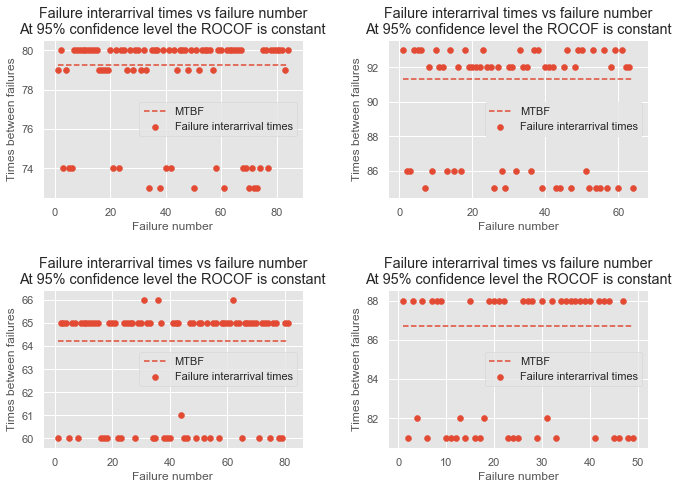

In [93]:
#Plotting rate of occurence of failures for each provider to get their MTBF trends
plt.figure(figsize=(10, 7))
plt.subplot(221)
ROCOF(times_between_failures=lifetime1.values)
plt.subplot(222)
ROCOF(times_between_failures=lifetime2.values)
plt.subplot(223)
ROCOF(times_between_failures=lifetime3.values)
plt.subplot(224)
ROCOF(times_between_failures=lifetime4.values)
plt.subplots_adjust(left=0.11, bottom=0.08, right=0.95, top=0.89, wspace=0.33, hspace=0.58)
plt.show()

As per plots above, all MTBFs are constant, not increasing (goal) neither decreasing (problems), with values very close to alpha or characteristic life parameter from their Weibull distributions.

Checking with reliability tools, helps to confirm that failures seen in assets from provider 3 are not related to maintenance issues due to beta parameter of 41, being way too large than a fraction between 0 and 1, which would indicate a maintenance issue.

As failure times can often appear quite random, it is necessary to conduct a statistical test to determine if there is a statistically significant trend. MTBF being constant, confirms there are no maintenance issues present on assets of provider 3.

This means that now, management has the proper information to decide whether provider 3 deserves to continue in company's suppliers pool, from reliability standpoint and bearing in mind assumption # 5, company should avoid continue purchasing assets from this supplier. If costs are added to analysis, it will just prove previous statement even more unless assets from provider 3 are considerably cheaper or there are capacity issues on other suppliers which are both very unlikely to happen. 

## Data pre-processing

In [202]:
#preparing categorical variables
df2 = pd.get_dummies(df, columns =['team', 'provider'])
df2.broken.replace('Yes', 1, inplace=True)
df2.broken.replace('No', 0, inplace=True)

In [203]:
#droping columns not needed
df2.drop(columns=['Random', 'Machine nbr'], inplace=True)
#Rearrenging columns order for splitting dataset into training and validation datasets
df2 = df2[['broken','lifetime','pressureInd','moistureInd','temperatureInd','team_1','team_2','team_3','provider_1','provider_2','provider_3','provider_4']]

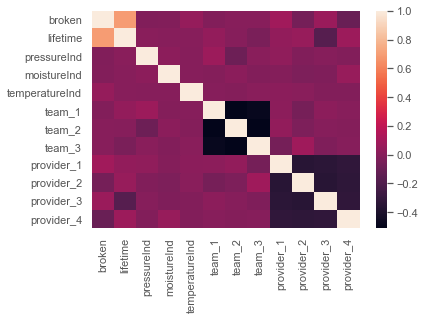

In [204]:
#Check the independence between the independent variables (covariates)
sns.heatmap(df2.corr())
plt.show()

Looks good, there are no correlation between independent variables.

In [205]:
#Split the data into training and validation sets
X = df2.iloc[:,1:]
y = df2.iloc[:,0]
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=0)

## Logistic regression model

In [166]:
#Initialize model, creating logistic regression object
model = LogisticRegression(random_state=0)
#Training model
logit = model.fit(X_train, y_train)

In [167]:
print(logit.coef_)

[[ 0.22290112 -0.00754252 -0.03939938 -0.00578799 -2.01024589 -2.4563243
  -0.97166074 -0.99334923 -3.1828053   1.72858362 -2.99066002]]


In [168]:
print(logit.intercept_)

[-7.24979271]


## Model evaluation and ROC curve

In [212]:
#Prediction with model
y_pred = logit.predict(X_val)
#Confusion matrix for model evaluation
confusion_matrix = confusion_matrix(y_val, y_pred)
#visualize confusion matrix
print(confusion_matrix)

[[84 16]
 [ 0 75]]


Model has 84+75=159 correct predictions and 0+16=16 wrong predictions.

* True positive: 84 (upper-left) – Number of positives we predicted correctly
* True negative: 75 (lower-right) – Number of negatives we predicted correctly
* False positive: 16 (top-right) – Number of positives we predicted wrongly
* False negative:  0 (lower-left) – Number of negatives we predicted wrongly

In [180]:
accuracyScore = accuracy_score(y_val, y_pred)
print('Accuracy of logistic regression classifier on validation set: {:.2f}'.format(model.score(X_val, y_val)))
print('Accuracy score: ', accuracyScore)
print('Accuracy score in percentage :', int(accuracyScore*100),'%')
print("Precision:",metrics.precision_score(y_val, y_pred))
print("Recall:",metrics.recall_score(y_val, y_pred))


Accuracy of logistic regression classifier on validation set: 0.91
Accuracy score:  0.9085714285714286
Accuracy score in percentage : 90 %
Precision: 0.8241758241758241
Recall: 1.0


Well, model got a classification rate of 90%, considered as good accuracy.

Precision: Precision is about being precise, i.e., how accurate your model is. In other words, you can say, when a model makes a prediction, how often it is correct. In your prediction case, when Logistic Regression model predicted failures are going to be accurate 82% of the time.

Recall: If there are machines who have failure in the test set and your Logistic Regression model can identify it 100% of the time.

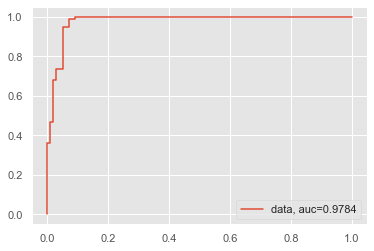

In [182]:
y_pred_proba = logit.predict_proba(X_val)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_val,  y_pred_proba)
auc = metrics.roc_auc_score(y_val, y_pred_proba)
plt.plot(fpr,tpr,label="data, auc="+str(auc))
plt.legend(loc=4)
plt.show()

AUC score for the case is 0.97. AUC score 1 represents perfect classifier, and 0.5 represents a worthless classifier.

## Predict failures with new dataset

Now, model is trained and validated, then it should be tested with new dataset for predictions made by model.

Each row is a case for failure prediction, this prediction should be evaluated in order to check for accuracy.
 
Data Source: https://mydatamodels.zendesk.com/hc/en-us/article_attachments/360037092371/Failure_prediction_-_For_prediction.csv

In [239]:
### Testing with new dataset
df3 = pd.read_csv('Failure-prediction-for-prediction.csv')
#df3

In [207]:
#preparing categorical variables
df4 = pd.get_dummies(df3, columns =['team', 'provider'])
df4.broken.replace('Yes', 1, inplace=True)
df4.broken.replace('No', 0, inplace=True)

In [208]:
#droping columns not needed
df4.drop(columns=['Random', 'Machine nbr'], inplace=True)
#Rearrenging columns order for splitting dataset into training and validation datasets
df4 = df4[['broken','lifetime','pressureInd','moistureInd','temperatureInd','team_1','team_2','team_3','provider_1','provider_2','provider_3','provider_4']]

In [210]:
#Split the data into training and validation sets
X2 = df4.iloc[:,1:]
y2 = df4.iloc[:,0]

In [237]:
#Prediction with model
y_pred2 = logit.predict(X2)

In [238]:
accuracyScore = accuracy_score(y2, y_pred2)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(model.score(X2, y2)))
print('Accuracy score: ', accuracyScore)
print('Accuracy score in percentage :', int(accuracyScore*100),'%')
print("Precision:",metrics.precision_score(y2, y_pred2))
print("Recall:",metrics.recall_score(y2, y_pred2))


Accuracy of logistic regression classifier on test set: 0.95
Accuracy score:  0.95
Accuracy score in percentage : 95 %
Precision: 0.8880597014925373
Recall: 1.0


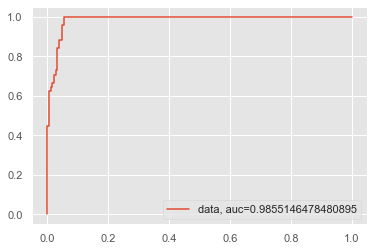

In [235]:
y_pred_proba2 = logit.predict_proba(X2)[::,1]
fpr, tpr, _ = metrics.roc_curve(y2,  y_pred_proba2)
auc = metrics.roc_auc_score(y2, y_pred_proba2)
plt.plot(fpr,tpr,label="data, auc="+str(auc))
plt.legend(loc=4)
plt.show()

AUC score for the test dataset is 0.98. Very good prediction power for each case (row) presented on test dataset.

## Conclusions:

This is also the goal of predictive maintenance (PdM) with a different approach: comparing values taken from field, either manually or online monitoring, comparing measurements against an pre-established alarm threshold, using thermography, vibration, and other techniques;  but sometimes the amount of machinery is so large that some analysts / planners could have problems trying to avoid unexpected failures on their fleets just based on these thresholds because they are not considering extra information from operations and taking decisions based only on these techniques.

Dataset provided for prediction is just an example found on internet; but it could be easily the current state of machinery from field taken from a SCADA (PLC/DCS), in order to predict its machinery failure odds, based on operating variables besides PdM variables, with the aim of planning & schedule an intervention on these machines before failure occurs with an extra layer of confidence.

Logistic regression technique provides an interesting way to increase the quality of prediction on maintenance staffs increasing overall equipment effectiveness (OEE) using their on site resources, combining reliability, data science, and process control.

In this case, we used logistic regression for simplicity purposes; but naive bayes, decision trees and random forests, which are also classification techniques from machine learning, might be helpful depending of the amount of data available, runtimes required, type of data available, assumptions, and other considerations. Once a good model is achieved in can be used in production for helping maintenance staffs to decide which equipment to inspect and repair, avoiding process interruptions.

Main takeaway is that data science and machine learning could help a lot to maintenance departments across many organizations in their goals to increase MTBFs of their fleets, as well as, their OEE KPI's for mobile or industrial assets, specially those involved with standard ISO55001, because companies can arrange or configure its own asset performance management solution (APM) using open source tools without purchasing expensive third party solutions and integrating them with their ERP/EAM. Combining IIoT and/or SCADA for data capture from field with machine learning on a company server might be the next move to achieve better operating results based on industry 4.0 standards.



